In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/CZ4041 Machine Learning Project/Colab/data

/content/drive/.shortcut-targets-by-id/1ldppAeVJfaoI4cvwZyTCju9jXbD4LI-H/CZ4041 Machine Learning Project/Colab/data


In [4]:
import pandas as pd
import numpy as np 
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

train = pd.read_csv('train.csv',parse_dates=True, index_col=['date'])
test = pd.read_csv('test.csv',parse_dates=True, index_col=['date'])
train 

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [5]:
def smape(x, x_):
    return 100 * np.mean(2 * np.abs(x - x_)/(np.abs(x) + np.abs(x_)))
    
def slope(y):
    Y = y.dropna()
    L = len(Y)
    x = np.arange(0, L)
    slope, intercept = np.polyfit(x, Y.values, deg=1)
    return slope

def intercept(y):
    Y = y.dropna()
    L = len(Y)
    x = np.arange(0, L)
    slope, intercept = np.polyfit(x, Y.values, deg=1)
    return intercept

In [6]:
test['sales'] = np.nan
df = pd.concat([train, test.loc[:, ['store', 'item', 'sales']]]).sort_values(by=['store', 'item'])

In [7]:
df['Qtr'] = df.index.quarter
df['M'] = df.index.month
df['D'] = df.index.weekday
df['Wk_b_num'] = [int(x) for x in np.floor((df.index - pd.to_datetime('2012-12-31')).days/7) + 1]
df['Qtr_b_num'] = (df.index.year - 2013) * 4 + df['Qtr']


In [8]:
slopeDF = df.groupby(['store', 'item', 'D'])['sales'].apply(slope).reset_index()
slopeDF.columns = ['store', 'item', 'D', 'lin_slope']
df = df.reset_index().merge(slopeDF, how='left', on=['store', 'item', 'D']).set_index('date')
interceptDF = df.groupby(['store', 'item', 'D'])['sales'].apply(intercept).reset_index()
interceptDF.columns = ['store', 'item', 'D', 'lin_intercept']
df = df.reset_index().merge(interceptDF, how='left', on=['store', 'item', 'D']).set_index('date')
df['lin_model'] = (df['Wk_b_num'] - 1) * df['lin_slope'] + df['lin_intercept']
df['drop_sales'] = df['sales'] - df['lin_model']

In [ ]:
seasonalYR = df.groupby(['store', 'item', 'D'])['drop_sales'].rolling(window=53, min_periods=53).apply(lambda x: x[-1]-x[0]).reset_index()
seasonalYR.columns = ['store', 'item', 'D', 'date', 'new']
seasonalYR = seasonalYR.sort_values(by=['store', 'item', 'date'])
df['new'] = seasonalYR['new'].values

In [ ]:
norm_sales = df.groupby(['store', 'item', 'D'])['new'].mean().reset_index()
norm_sales.columns = ['store', 'item', 'D', 'diff_mean']
df = df.reset_index().merge(norm_sales, how='left', on=['store', 'item', 'D']).set_index('date')

diff_std_df = df.groupby(['store', 'item', 'D'])['new'].std().reset_index()
diff_std_df.columns = ['store', 'item', 'D', 'diff_std']
df = df.reset_index().merge(diff_std_df, how='left', on=['store', 'item', 'D']).set_index('date')

df['norm_diff'] = (df['new'] - df['diff_mean']) / df['diff_std']


In [ ]:
df['outlier'] = (abs(df['norm_diff']) > 3) * 1

corrected_sales = []
for ind, row in df[df['outlier']==1].iterrows():
    past_Wk = ind - pd.Timedelta('7 days')
    next_Wk = ind + pd.Timedelta('7 days')
    store = row['store']
    item = row['item']
    past_Wk_sales = df.loc[past_Wk][(df.loc[past_Wk]['store']==store) & 
    (df.loc[past_Wk]['item']==item)]['sales'].values[0]
    next_Wk_sales = df.loc[next_Wk][(df.loc[next_Wk]['store']==store) & 
    (df.loc[next_Wk]['item']==item)]['sales'].values[0]
    interpolated_sales = 0.5 * (past_Wk_sales + next_Wk_sales)
    corrected_sales.append(interpolated_sales)
df.loc[df['outlier']==1, 'sales'] = corrected_sales

In [9]:
df.drop(columns = ['lin_model', 'lin_slope', 'lin_intercept', 'drop_sales', 'new', 'diff_mean', 'diff_std', 'norm_diff', 'outlier'], inplace=True)   
df = df.sort_values(by=['item', 'store'])

In [11]:
for item in ['D', 'M', 'Qtr']:
    df1 = df.groupby(['store', 'item', item])['sales'].expanding().mean().shift(1).bfill().reset_index()
    df1.columns = ['store', 'item', item,'date', item + '_ex_avg_sale']
    df1 = df1.sort_values(by=['item', 'store', 'date'])
    df[item + '_ex_avg_sale'] = df1[item + '_ex_avg_sale'].values
    
avg_sales= df.groupby(['store', 'item'])['sales'].mean()
critical_val = avg_sales.quantile(0.5)
critical_st = avg_sales[avg_sales< critical_val].reset_index()
critical_st.drop(columns=['sales'], inplace=True)
critical_st['critical'] = 1
df = df.reset_index().merge(critical_st, how='left', on=['store', 'item']).set_index('date')
df['critical'] = df['critical'].fillna(0)
df = df.sort_values(by=['item', 'store'])

In [12]:
used_feats = ['M_ex_avg_sale', 'D_ex_avg_sale', 'Qtr_ex_avg_sale',
              'M', 'D', 'Qtr_b_num', 'critical', 'sales']
df = df.loc[:, used_feats]

In [13]:
training_df = df.loc['2013':'2017']
testing_df = df.loc['2018']

In [14]:
critical_store_item_mask = testing_df['critical']==1
training_df.drop(columns=['critical'], inplace=True)
testing_df.drop(columns=['critical'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Training until validation scores don't improve for 50 rounds.
[2000]	valid_0's mape: 0.132326
[4000]	valid_0's mape: 0.132052
Early stopping, best iteration is:
[4110]	valid_0's mape: 0.132035
validation smape:  12.596475638871734
validation mae:  5.602650597970136


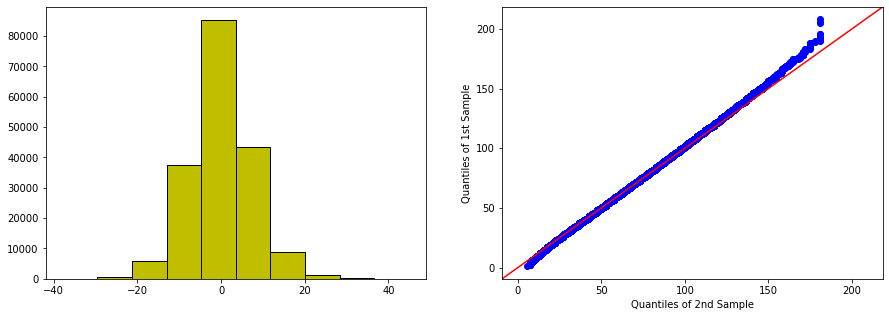

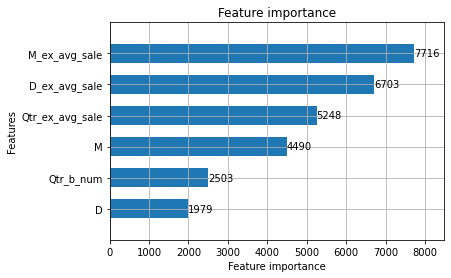

In [15]:
X = training_df.loc[:, [col for col in training_df.columns if col not in ['sales']]]
y = training_df['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'max_depth': 3,
    'metric' : 'mape',
    'learning_rate': 0.1
}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_val,
                early_stopping_rounds=50,
                verbose_eval=2000)

preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)

print('validation smape: ', smape(y_val, preds))
print('validation mae: ', mean_absolute_error(y_val, preds))
error = y_val.values - preds

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.hist(error, EDGECOLOR='black', color='y')
sm.qqplot_2samples(y_val.values, preds, line='45', ax=plt.subplot(1, 2, 2))
plt.show()

lgb.plot_importance(gbm, height=0.6)
plt.show()

In [16]:
X_train = training_df.loc[:, [col for col in training_df.columns if col not in ['sales']]].values 
y_train = training_df['sales'].values
X_test = testing_df.loc[:, [col for col in testing_df.columns if col not in ['sales']]]
lgb_train = lgb.Dataset(X_train, y_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'max_depth': 3,
    'learning_rate': 0.1
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000)
test_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
testing_df.loc[:,'sales'] = test_preds
testing_df.loc[critical_store_item_mask, 'sales'] = testing_df.loc[critical_store_item_mask, 'sales'] * 0.99

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
sample_submission = testing_df['sales'].values
sample_submission

array([12.07589453, 14.19843136, 14.24857003, ..., 77.30908342,
       83.99469027, 88.91847846])

In [ ]:
%cd ..
createSubmission(sample_submission)

/content/drive/.shortcut-targets-by-id/1ldppAeVJfaoI4cvwZyTCju9jXbD4LI-H/CZ4041 Machine Learning Project/Colab


In [ ]:
def createSubmission(predictions,fileName="data/submission15.csv"):
  df=pd.DataFrame(predictions)
  df=df.reset_index()
  df.columns=['id','sales']
  df.to_csv(fileName,index=False)